##  LAB 03 : Audio Sound source Separation Using Non-Negative Matrix Factorization

---

Made by : **Zahra BENSLIMANE** and **Mhamed BENABID**

Lab instructor: **Nicolas Obin.** 


<div class="alert alert-block alert-info"> 

<b> The Non-Negative Matrix Multiplication :</b> 

---   
    
The cost function :    
    
$\beta Div = \frac{1}{\beta(\beta -1)}(V^\beta + (\beta -1)[WH]^\beta - \beta V[WH]^{\beta -1}
))$


$\beta Div (V|WH) = \frac{1}{\beta(\beta -1)} \sum_{ij}(V_{i,j}^\beta + (\beta -1)[WH]{i,j}^\beta - \beta V{i,j}[WH]_{i,j}^{\beta -1})$

$\beta Div (V|WH) = \frac{1}{\beta(\beta -1)} \sum_{ij} ( (\beta -1)[WH]{i,j}^{\beta-1} \frac{\partial [WH]{i,j}}{\partial \theta_{p,q}} - \beta(\beta -1) V_{i,j}[WH]{i,j}^{\beta -2} \frac{\partial [WH]{ij}}{\partial \theta_{p,q}}
)$

$
\beta Div (V|WH) =  \sum_{ij} ( [WH]{i,j}^{\beta-1} \frac{\partial [WH]{i,j}}{\partial \theta_{p,q}} ) - \sum_{ij} ( \beta V_{i,j}[WH]{i,j}^{\beta -2} \frac{\partial [WH]{ij}}{\partial \theta_{p,q}}
)$

*We have :* 
$$[WH]_{i,j} = \sum_{k} W_{i,j} H_{k,j}$$

*so,if we derive over H, we get :*
$$\frac{\partial [WH]{i,j}}{\partial H{p,q}} = \sum_{k} W_{i,j} \frac{\partial H_{k,j}}{\partial H_{p,q}}$$


$$\frac{\partial [WH]{i,j}}{\partial H{p,q}} =\sum_{K} W_{i,j} \delta_{j,q} \delta_{k,p} = W_{i,p} \delta_{j,q}  -----(*) $$


*And, if we derive over W :*

$$\frac{\partial [WH]_{i,j}}{\partial W{p,q}} = \sum_{k} \frac{\partial W_{i,k}}{\partial W_{p,q}} H_{k,j} $$

$$\frac{\partial [WH]_{i,j}}{\partial W{p,q}} =\sum_{K} \delta_{i,p} \delta_{k,q} H_{k,j}  = \delta_{i,p} H_{q,j} -----(**) $$



if we replace (\*) and (**) in the following equations : 

$$\frac{\beta Div (V|WH)}{\partial W_{p,q}} =  \sum_{ij} ( [WH]_{i,j}^{\beta-1} \frac{\partial [WH]{i,j}}{\partial W_{p,q}} ) - \sum_{ij} ( V_{i,j}[WH]_{i,j}^{\beta -2} \frac{\partial [WH]_{ij}}{\partial W_{p,q}}
)$$

$$\frac{\beta Div (V|WH)}{\partial H_{p,q}} =  \sum_{ij} ( [WH]{i,j}^{\beta-1} \frac{\partial [WH]{i,j}}{\partial H_{p,q}} ) - \sum_{ij} ( V_{i,j}[WH]_{i,j}^{\beta -2} \frac{\partial [WH]_{ij}}{\partial H_{p,q}}
)$$

*we will end up with :*


$$\frac{\beta Div (V|WH)}{\partial W_{p,q}} =  (WH)^{\beta-1}  H^T  - [(WH)^{\beta -2}V]  H^T 
)$$


$$\frac{\beta Div (V|WH)}{\partial H_{p,q}} =    W^T(WH)^{\beta-1}   - W^T[(WH)^{\beta -2}V]$$


*Knowing that :*
$$W^{(i+1)} = W^{(i)} \bigotimes \frac{\nabla_W^-C}{\nabla_W^+C}$$

$$H^{(i+1)} = H^{(i)} \bigotimes \frac{\nabla_H^-C}{\nabla_H^+C}$$


*We get :*

$$W^{(i+1)} = W^{(i)} \bigotimes \frac{[(WH)^{\beta -2}V]  H^T }{(WH)^{\beta-1}  H^T}$$

$$H^{(i+1)} = H^{(i)} \bigotimes \frac{W^T[(WH)^{\beta -2}V]}{ W^T(WH)^{\beta-1}}$$
    
    
</div>


#### Import  libraries

In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display
import IPython.display as ipd

#### Load audio recording

In [20]:
audio = 'piano_mix.wav'

In [21]:
sample_rate = 5512
# Load audio signal
y_sound, sr = librosa.load(audio, sr = sample_rate)
# Display audio
ipd.Audio(y_sound,rate = sr)

#### Compute Short Term Fourier Transform of the signal

In [ ]:
FRAME = 512
HOP = 256

# Return the complex Short Term Fourier Transform
sound_stft = librosa.stft(y_sound, n_fft = FRAME, hop_length = HOP)

Text(0.5, 1.0, 'Audio spectrogram')

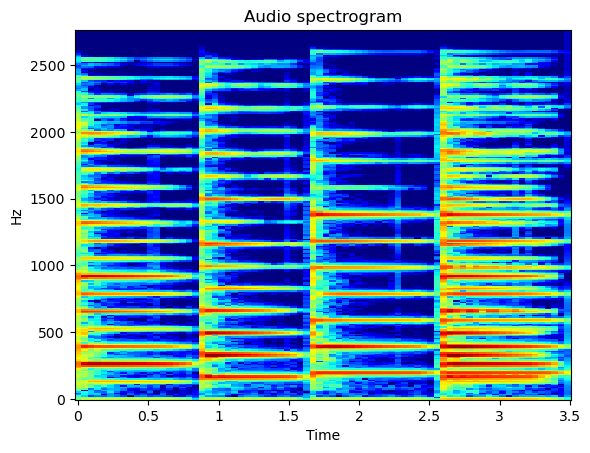

In [220]:
# Magnitude Spectrogram
sound_stft_M = np.abs(sound_stft)

# Phase spectrogram
sound_stft_A = np.angle(sound_stft)

#Plot Spectogram
D = librosa.amplitude_to_db(sound_stft_M, ref = np.max)
librosa.display.specshow(D,y_axis = 'hz',sr=sr,hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet)
plt.title('Audio spectrogram')

# Non-Negative Matrix Factorisation

In [221]:
epsilon = 1e-10

V = sound_stft_M + epsilon
K, N = np.shape(V)
print(f"K = {K} : Sources")
print(f"N = {N}  : Microphones")

S = 4 
print(f"S = {S} : Number of Sources to separate")

K = 257 : Sources
N = 76  : Microphones
S = 4 : Number of Sources to separate


#### Define a fonction that computes the $\beta$ Divergence

In [222]:
def divergence(V,W,H, beta = 2):
    
    """
    beta = 2 : Euclidean cost function
    beta = 1 : Kullback-Leibler cost function
    beta = 0 : Itakura-Saito cost function
    """ 
    
    if beta == 0 : return np.sum( V/(W@H) - math.log10(V/(W@H)) -1 )
    
    if beta == 1 : return np.sum( V*math.log10(V/(W@H)) + (W@H - V))
    
    if beta == 2 : return 1/2*np.linalg.norm(W@H-V)
    

In [223]:
def plot_NMF_iter(W, H,beta,iteration = None):
    
    f = plt.figure(figsize=(4,4))
    f.suptitle(f"NMF Iteration {iteration}, for beta = {beta}", fontsize=8,)
    
    # definitions for the axes
    V_plot = plt.axes([0.35, 0.1, 1, 0.6])
    H_plot = plt.axes([0.35, 0.75, 1, 0.15])
    W_plot = plt.axes([0.1, 0.1, 0.2, 0.6])

    D = librosa.amplitude_to_db(W@H, ref = np.max)

    librosa.display.specshow(W,y_axis = 'hz', sr=sr, hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax=W_plot)
    librosa.display.specshow(H,y_axis = 'hz', sr=sr, hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax=H_plot)
    librosa.display.specshow(D,y_axis = 'hz', sr=sr, hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax=V_plot)

    W_plot.set_title('Dictionnary W', fontsize=10)
    H_plot.set_title('Temporal activations H', fontsize=10)

    W_plot.axes.get_xaxis().set_visible(False)
    H_plot.axes.get_xaxis().set_visible(False)
    V_plot.axes.get_yaxis().set_visible(False)

Stop after 5000 iterations.


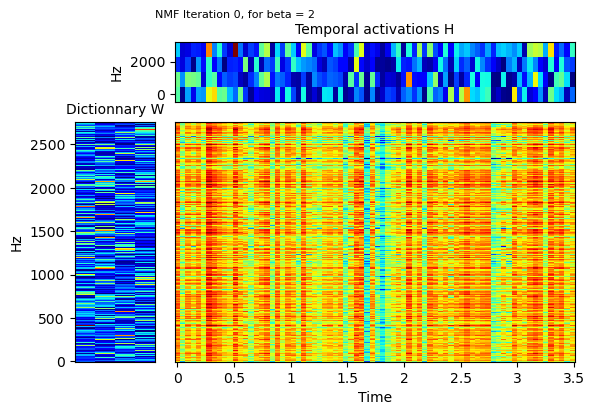

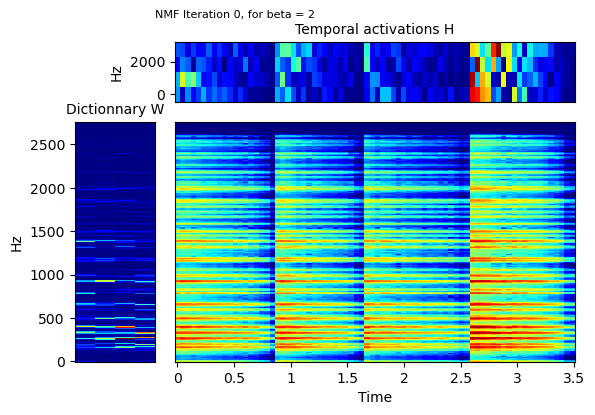

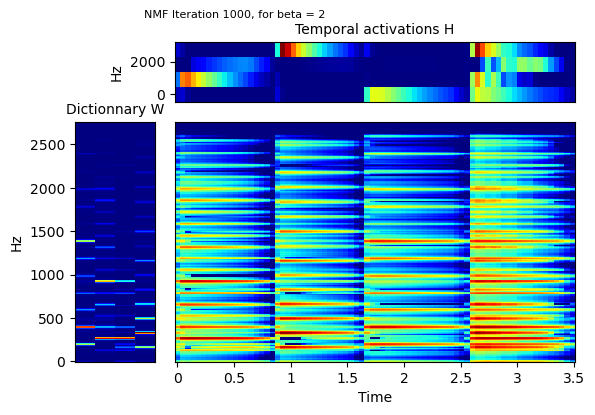

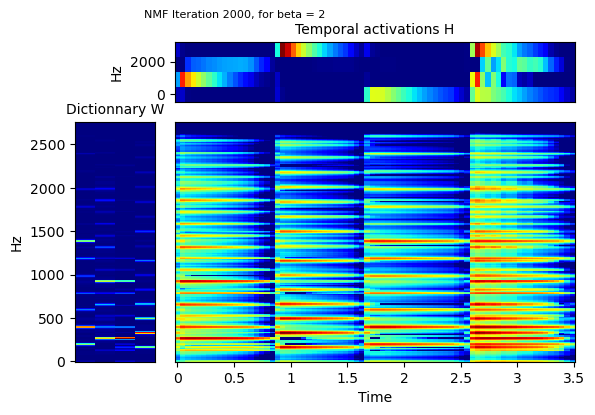

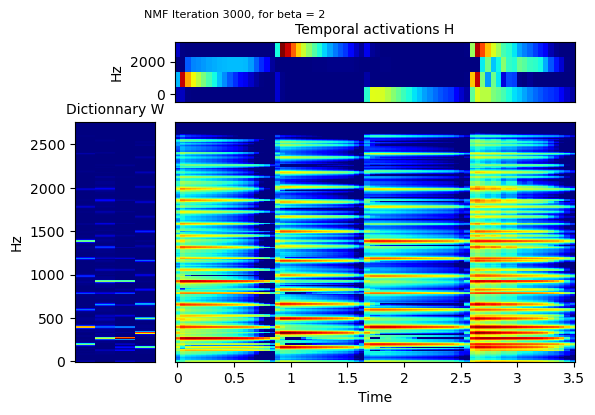

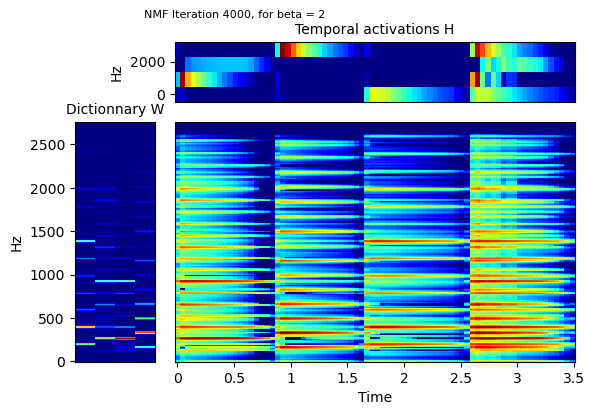

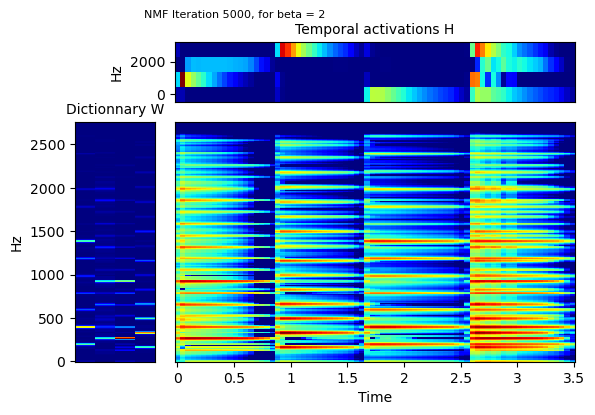

In [230]:
def NMF(V, S, beta = 2,  threshold = 0.05, MAXITER = 5000, display = True , displayEveryNiter = None): 
    
    """
    inputs : 
    --------
    
        V         : Mixture signal : |TFST|
        S         : The number of sources to extract
        beta      : Beta divergence considered, default=2 (Euclidean)
        threshold : 
        MAXITER   : The number of maximum iterations, default=1000
        display   : Display plots during optimization : 
        displayEveryNiter : only display last iteration 
                                                        
        
    
    outputs :
    ---------
      
        W : dictionary matrix [KxS], W>=0
        H : activation matrix [SxN], H>=0
        cost_function : the optimised cost function over iterations
       
   Algorithm : 
   -----------
   
    1) Randomly initialize W and H matrices
    2) Multiplicative update of W and H 
    3) Repeat step (2) until convergence or after MAXITER 
    
       
    """
    counter  = 0
    cost_function = []
    beta_divergence = 1
    
    K, N = np.shape(V)
    
    # Initialisation of W and H matrices : The initialization is generally random
    W = np.abs(np.random.normal(loc=0, scale = 2.5, size=(K,S)))    
    H = np.abs(np.random.normal(loc=0, scale = 2.5, size=(S,N)))
    
    # Plotting the first initialization
    if display == True : plot_NMF_iter(W,H,beta,counter)
    
    #W = np.abs(np.random.rand(K,S))  
    #H = np.abs(np.random.rand(S,N))

    while beta_divergence >= threshold and counter <= MAXITER:
        
        # Update of W and H
        H *= (W.T@(((W@H)**(beta-2))*V))/(W.T@((W@H)**(beta-1)) + 10e-10)
        W *= (((W@H)**(beta-2)*V)@H.T)/((W@H)**(beta-1)@H.T + 10e-10)
        
        # Update of W and H
        #H *= (W.T@V)/(W.T@(W@H))
        #W *= (V@H.T)/((W@H)@H.T)
        
        # Compute cost function
        beta_divergence =  divergence(V,W,H, beta = 2)
        cost_function.append( beta_divergence )
        
        if  display == True  and counter%displayEveryNiter == 0  : plot_NMF_iter(W,H,beta,counter)

        counter +=1
    
    if counter -1 == MAXITER : print(f"Stop after {MAXITER} iterations.")
    else : print(f"Convergeance after {counter-1} iterations.")
        
    return W,H, cost_function

beta = 2
W, H, cost_function = NMF(V,S,beta = beta, threshold = 0.05, MAXITER = 5000, display = True , displayEveryNiter = 1000)    

In [231]:
print(np.shape(W))
print(np.shape(H))

(257, 4)
(4, 76)


#### Plotting the cost Function

Text(0, 0.5, 'Beta Divergence for beta = 2 ')

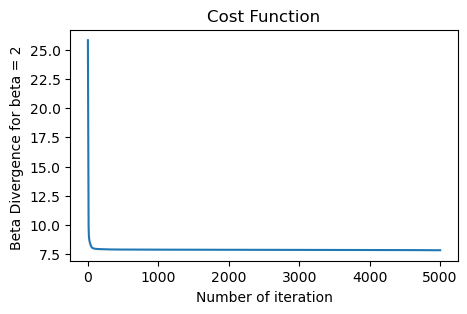

In [232]:
# Plot the cost function
plt.figure(figsize=(5,3))
plt.plot(cost_function)
plt.title("Cost Function")
plt.xlabel("Number of iteration")
plt.ylabel(f"Beta Divergence for beta = {beta} ")

### Extraction the different sources

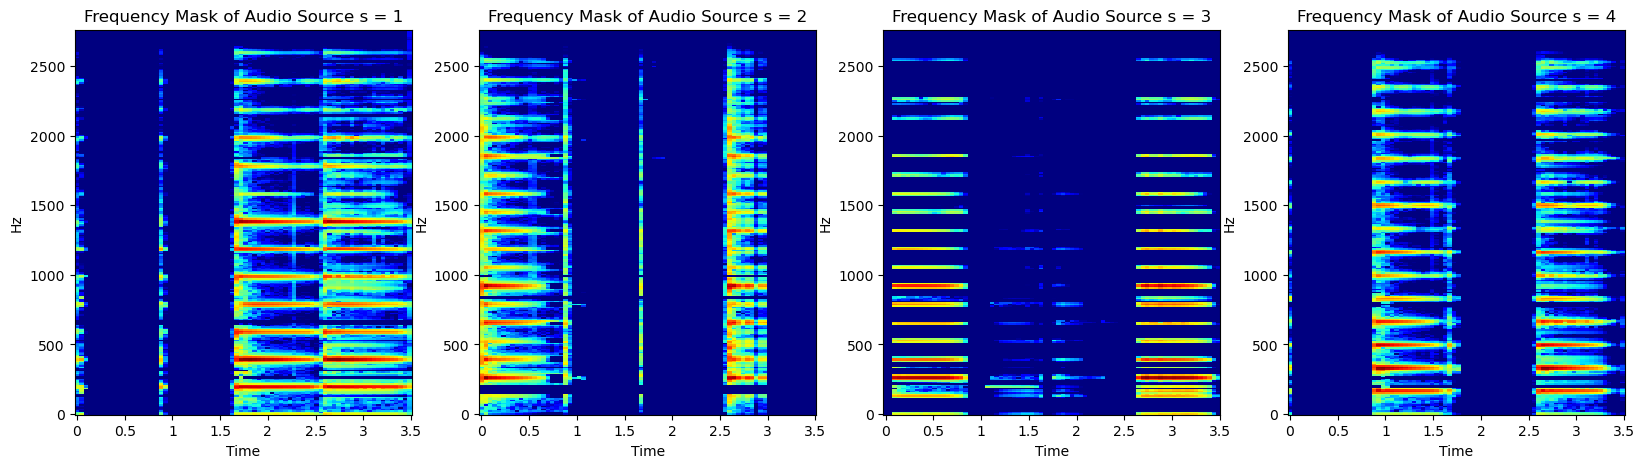

In [233]:
#After NMF, each audio source S can be expressed as a frequency mask over time
f, axs = plt.subplots(nrows=1, ncols=S,figsize=(20,5))
filtered_spectrograms = []
for i in range(S):
    axs[i].set_title(f"Frequency Mask of Audio Source s = {i+1}")
        
    WsHs = W[:,[i]]@H[[i],:]
    filtered_spectrogram = W[:,[i]]@H[[i],:] / (W@H) * V
    D = librosa.amplitude_to_db(filtered_spectrogram, ref = np.max)
    librosa.display.specshow(D,y_axis = 'hz', sr=sr,hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax = axs[i])
    
    filtered_spectrograms.append(filtered_spectrogram)

In [215]:
reconstructed_sounds = []
for i in range(S):
    reconstruct = filtered_spectrograms[i] * np.exp(1j*sound_stft_A)
    new_sound   = librosa.istft(reconstruct, n_fft = FRAME, hop_length = HOP)
    
    print(new_sound.shape)
    reconstructed_sounds.append(new_sound)

(19200,)
(19200,)
(19200,)
(19200,)


In [211]:
for i in range(S):
    ipd.display(f"Source {i}",ipd.Audio(reconstructed_sounds[i], rate=sr))

'Source 0'

'Source 1'

'Source 2'

'Source 3'

### Réaliser les étapes précédentes en faisant varier β=2, β=1, β=0

Stop after 5000 iterations.
Stop after 5000 iterations.
Stop after 5000 iterations.


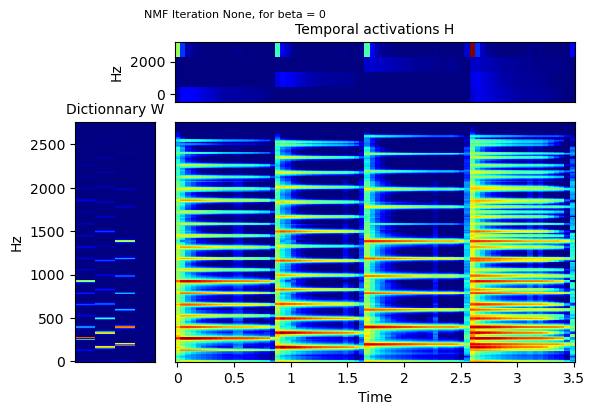

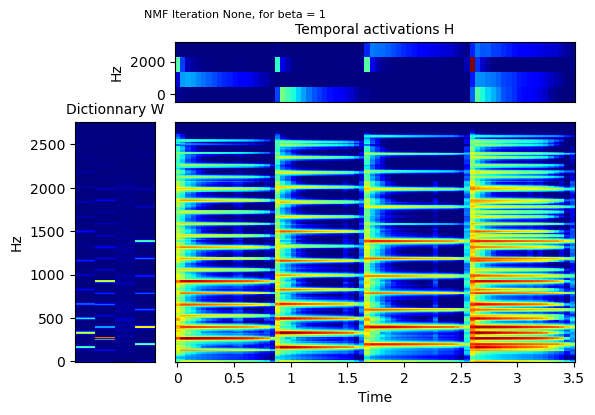

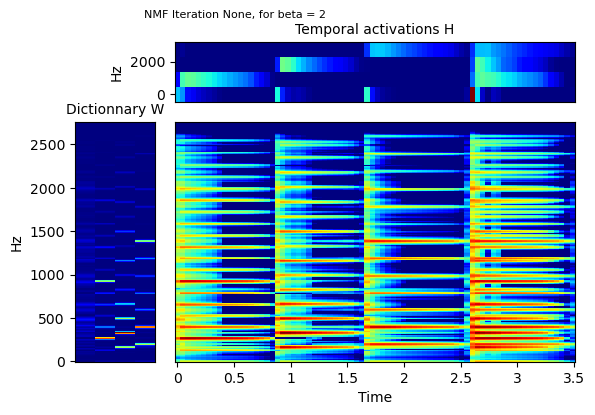

In [214]:
for beta in [0,1,2]:
    W, H, cost_function = NMF(V,S,beta = beta, threshold = 0.05, MAXITER = 5000, display = False) 
    plot_NMF_iter(W, H,beta)

Commentaires 